# Evaluating and Tuning a Binary Classification Model

## Goals

After this lesson, you should be able to:

- Build and explain confusion matrices from a model output
- Calculate various binary classification metrics
- Explain the AUC/ROC curve, why it matters, and how to use it
- Understand when and how to optimize a model for various metrics
- Optimize a classification model based on costs

## Heart Disease Data Set

In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt

[Dataset info](https://archive.ics.uci.edu/ml/datasets/Heart+Disease)

In [3]:
df = pd.read_csv('./data/heart.csv')

In [4]:
print(df.shape)
df.head(3)

(303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1


In [5]:
## A row is a patient

## Each column  is some measurements from this patient. 

## Colum: target: Whether this patient has a heart disease or not (if yes = 1 (positive), otherwise = 0 or negative)

In our dataset we have 303 patients and 13 independent variables and 1 binary target variable.

When we are working with classification problems it is always good practice to check the class balance.

In [6]:
df['target'].value_counts(normalize = True)

1    0.544554
0    0.455446
Name: target, dtype: float64

We see that approximately %54 of the patients are in the class 0 which refers to 'no presence' of a heart disease. Consequently, %45 of the patients have a heart disease. 

## Creating Train-Test Split

In [30]:
## For model evaluation we split our data into two parts: Train - Test

X = df.drop('target', axis = 1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state = 77, 
                                                    stratify = y, # in classification problems 
                                                                  # when you split the data 
                                                                  # you want to keep the ratio in the classes.
                                                    test_size = .2 # This is usually the ratio but it might change 
                                                                   # according to the problem at hand.
                                                   )

In [31]:
## Let's check number of 1 and 0 in both datasets
y_train.mean(), y_test.mean()

(0.5454545454545454, 0.5409836065573771)

!! Now __forget__ the test set

[sklearn - Why do we need Train-Test-Validation?](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation)

## Choosing a Perfomance Metric for Model Evaluations

__Model Selection vs Model Evaluation__

- Model Selection/Model Comparison: What is the best parameters for a given model. Between different models which one is better models the reality.

Ex: If we are working with an app that runs a machine learning algorithm model selection is choosing the process of choosing a final algorithm to deploy.


- Model Evaluation: After selecting a 'best' model with model selection how this model will perform in the 'real' case.

Ex: Model evaluation is where we want to predict how successful this algorithm will be.

[Available tools in sklearn](https://scikit-learn.org/stable/model_selection.html)

<img src= 'images/table.png' width = 450 />

### Accuracy

$$\text{Accuracy} =  \frac{\text{# of Correct Predictions}}{\text{# of Total Cases}}$$

- Accuracy overall gives a good idea about an estimators performance but sometimes it is not directly relevant to the problem. (Especially in imbalanced dataset we should expect that event the dummy model could perform a high accuracy.)

### Recall

$$ \text{Recall} = \frac{\text{# True Positives}}{\text{# of Condition Positive}} = \frac{\text{TP}}{\text{TP + FN}} $$

- __Q__: Given that the total number of "Condition Positives" are fixed. How can we improve the __Recall__ score?


- In our case, recall score corresponds to out of 100 patients with heart disease how many of them are succesfully predicted as positive.

### Precision

$$ \text{Precision} = \frac{\text{# True Positives}}{\text{# of Predicted Positive}} = \frac{\text{TP}}{\text{TP + FP}} $$

- __Q__: Given that the total number of "Condition Positives" are fixed. How can we improve the __Precision__ score?

- In our case, precision score corresponds to: out of 100 positive prediction how many of them are really the having heart disease.

__Your turn__

- Suppose we are trying to classify videos whether they are safe for kids or not. Which metric does make more sense to use? (safe = 1, not_safe = 0)

- We are training a classification algorithm for fraud detection for a bank. Which metric does make more sense to use? (fraud = 1, normal = 0)

## Data Prep Before Training a Model

[A good blog post on handling categorical variables](https://www.bogotobogo.com/python/scikit-learn/scikit_machine_learning_Data_Preprocessing-Missing-Data-Categorical-Data.php)

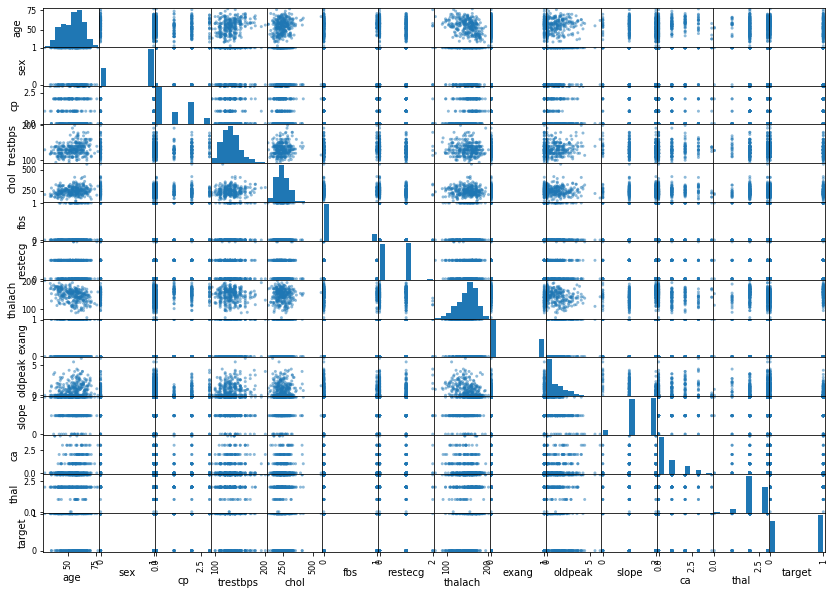

In [32]:
# we can also check the categorical variables with scatter matrix plot
# but notice that this is not practical in higher dimensions
pd.plotting.scatter_matrix(df, figsize= (14, 10))
plt.show()

In [33]:
categorical_variables = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

In [34]:
remaining_list = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

[There are many interesting tools for processing data](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_selector.html#sklearn.compose.make_column_selector)

__Your Turn__

- Convert Categorical Variables to OneHotEncoding

- [Dummies vs OneHot: Read the second answer](https://stackoverflow.com/questions/36631163/pandas-get-dummies-vs-sklearns-onehotencoder-what-are-the-pros-and-cons)

In [35]:
pd.get_dummies(X_train, columns= categorical_variables, drop_first= True).shape

(242, 22)

Now try to transform test data with get_dummies method.

In [36]:
pd.get_dummies(X_test, columns= categorical_variables, drop_first= True).shape

(61, 21)

In [37]:
from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler

In [42]:
ss = StandardScaler()

In [43]:
## create an encoder object. This will help us to convert
## categorical variables to new columns
encoder = OneHotEncoder(handle_unknown= 'error',
                        drop='first',
                        categories= 'auto')

## Create an columntransformer object.
## This will help us to merge transformed columns
## with the rest of the dataset.

ct = ColumnTransformer(transformers =[('ohe', encoder, ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal'])],
                                    remainder= ss)
ct.fit_transform(X_train)
X = ct.transform(X_train)

In [44]:
X.shape

(242, 22)

In [46]:
ct.transform(X_test)

array([[ 1.        ,  0.        ,  0.        , ..., -0.37271932,
        -0.91052568,  1.38038749],
       [ 1.        ,  0.        ,  1.        , ..., -0.9949091 ,
         0.10327427,  0.16343386],
       [ 1.        ,  0.        ,  0.        , ..., -0.4893799 ,
         1.38154376, -0.87966926],
       ...,
       [ 1.        ,  0.        ,  1.        , ...,  0.19114017,
        -0.11711703, -0.53196822],
       [ 1.        ,  1.        ,  0.        , ..., -1.09212625,
         1.07299595, -0.87966926],
       [ 1.        ,  0.        ,  0.        , ..., -1.07268282,
         0.54405685,  0.77191067]])

In [47]:
ct.transform(X_test).shape

(61, 22)

In [48]:
ct.transformers_[0][1].get_feature_names(categorical_variables)

array(['sex_1', 'cp_1', 'cp_2', 'cp_3', 'fbs_1', 'restecg_1', 'restecg_2',
       'exang_1', 'slope_1', 'slope_2', 'ca_1', 'ca_2', 'ca_3', 'ca_4',
       'thal_1', 'thal_2', 'thal_3'], dtype=object)

In [49]:
X[:5, :6]

array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 1., 0., 0., 1., 1.],
       [1., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 1., 0.]])

Now try to transform test dataset by using ct object.

__Don't forget!!__

- Apply the same transformations to the test data.

In [50]:
Xtest  = ct.transform(X_test)
Xtest.shape

(61, 22)

__Scaling Features__  It is not necessary any more!!!!

-- Let's go back to the column transformer.

[Different Scalers and Their Effect on Data](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py)

In [51]:
from sklearn.preprocessing import StandardScaler

In [52]:
standard_scaler = StandardScaler()
standard_scaler.fit(X)
X = standard_scaler.transform(X)
## apply the trained transformations to test.

Xtest = standard_scaler.transform(Xtest)

In [ ]:
X_test.shape

In [ ]:
np.mean(X,axis = 0)

## What do you expect if you check the means of X_test? Try

## Model Training

[Check sklearn for documentation of Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)


[For solvers](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)

In [53]:
log_reg = LogisticRegression(penalty = 'none', max_iter= 10000)
log_reg.fit(X, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [54]:
## What is this score?
print(log_reg.score(X, y_train))

0.8925619834710744


In [55]:
## Accuracy score

## Confusion Matrix

In [56]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [57]:
y_pred = log_reg.predict(X)

score = log_reg.score(X, y_train)


In [58]:
cm = confusion_matrix(y_train, y_pred)

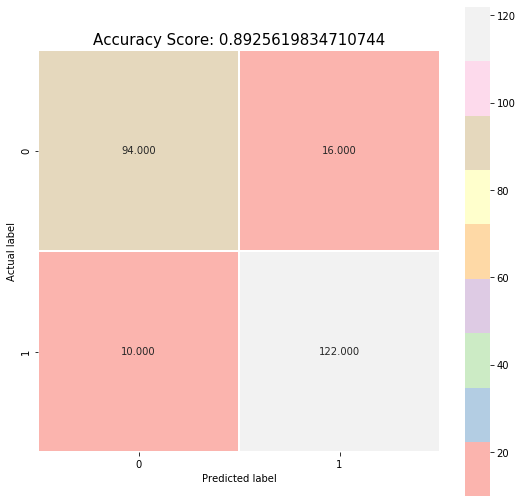

In [59]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Pastel1');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);
plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
#plt.show();


__Your Turn__

- Find Recall and Precision scores

__Reminder__

$$ \text{True Positive Rate} = \text{Recall} = \frac{\text{# True Positives}}{\text{# of Condition Positive}} = \frac{\text{TP}}{\text{TP + FN}} $$

$$ \text{Precision} = \frac{\text{# True Positives}}{\text{# of Predicted Positive}} = \frac{\text{TP}}{\text{TP + FP}} $$

In [ ]:
## find them here

### Using sklearn for precision and recall

In [ ]:
## Recall

In [60]:
from sklearn.metrics import recall_score

In [61]:
recall_score(y_train, y_pred)

0.9242424242424242

In [62]:
from sklearn.metrics import precision_score

In [63]:
precision_score(y_train, y_pred)

0.8840579710144928

In [64]:
## there are other important metrics too

from sklearn.metrics import f1_score

f1_score(y_train, y_pred)

0.9037037037037037

### Using Cross Validation Scores for Model Evaluation

In [67]:
from sklearn.model_selection import cross_val_score

In [71]:
log_reg = LogisticRegression(penalty = 'none', max_iter= 10000,  )

In [69]:
y_scores = cross_val_score(log_reg, X, y_train, cv = 5, scoring= 'recall')

In [70]:
y_scores

array([0.85185185, 0.81481481, 0.88461538, 0.84615385, 0.92307692])

## ROC Curves for Model Selection

<img src='./images/conf_matrix_classification_metrics.png' width=650/>

In [110]:
log_reg_vanilla = LogisticRegression(penalty= 'none', max_iter= 10000)

log_reg_l2 = LogisticRegression(penalty = 'l2', C = 10, max_iter= 10000)

In [111]:
log_reg_vanilla.fit(X, y_train)

y_probs_vanilla = log_reg_vanilla.predict_proba(X)

In [112]:
log_reg_l2.fit(X, y_train)
y_probs_l2 = log_reg_l2.predict_proba(X)

In [113]:
y_probs_l2[:5, :]

array([[0.19289457, 0.80710543],
       [0.30059102, 0.69940898],
       [0.04769788, 0.95230212],
       [0.59494707, 0.40505293],
       [0.80111353, 0.19888647]])

In [114]:
y_label = log_reg_l2.predict(X)

y_label[:5]

array([1, 1, 1, 0, 0])

In [115]:
## let's change the treshold to see the effect of it on FPR and TPR

In [125]:
predicts = []
for item in log_reg_vanilla.predict_proba(X):
    if item[1] <= .1:
        predicts.append(0)
    else:
        predicts.append(1)
        
conf_matrix = pd.DataFrame(confusion_matrix(y_train, predicts),
                           index = ['actual 0', 'actual 1'], 
                           columns = ['predicted 0', 'predicted 1'])
conf_matrix

,predicted 0,predicted 1
actual 0,64,46
actual 1,1,131


### Plotting ROC curves

In [117]:
import matplotlib.pyplot as plt

%matplotlib inline

In [118]:
from sklearn.metrics import roc_curve

In [119]:
fpr_v, tpr_v, thresholds_v = roc_curve(y_train, y_probs_vanilla[:,1])
fpr_l2, tpr_l2, thresholds_l2 = roc_curve(y_train, y_probs_l2[:,1])

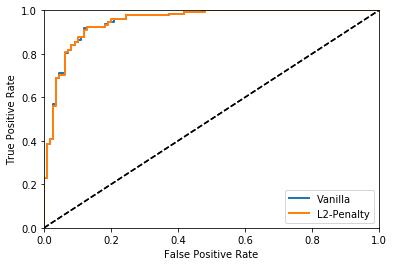

In [120]:
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth =2 , label = label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr_v, tpr_v, label = 'Vanilla')
plot_roc_curve(fpr_l2, tpr_l2, label = 'L2-Penalty')
plt.legend()
plt.show()

Also we can measure the __A__rea __U__nder __C__urve scores


In [121]:
from sklearn.metrics import roc_auc_score

In [122]:
## for 
roc_auc_score(y_train, y_probs_vanilla[:,1])

0.9497245179063362

In [123]:
roc_auc_score(y_train, y_probs_l2[:,1])

0.9496556473829201

### The Default Measure (in most prebuilt models) - Accuracy

$$ \frac{(TP + TN)}{(TP + FP + TN + FN)} $$

<img src='./images/conf_matrix_classification_metrics.png' width=650/>

Category definitions - possible outcomes in binary classification

- TP = True Positive (class 1 correctly classified as class 1) - e.g. Patient with cancer tests positive for cancer
- TN = True Negative (class 0 correctly classified as class 0) - e.g. Patient without cancer tests negative for cancer
- FP = False Positive (class 0 incorrectly classified as class 1) - e.g. Patient without cancer tests positive for cancer
- FN = False Negative (class 1 incorrectly classified as class 0) - e.g. Patient with cancer tests negative for cancer

 $$ \text{Possible misclassifications} $$

<img src='./images/type-1-type-2.jpg' width=400/>
 

Remember that Logistic Regression gives probability predictions for each class, in addition to the final classification. By default, threshold for the prediction is set to 0.5, but we can adjust that threshold.

In [ ]:
predicts = []
for item in log_reg_vanilla.predict_proba(X):
    if item[1] <= .20:
        predicts.append(0)
    else:
        predicts.append(1)

In [ ]:
conf_matrix = pd.DataFrame(confusion_matrix(y_train, predicts),
                           index = ['actual 0', 'actual 1'], 
                           columns = ['predicted 0', 'predicted 1'])
conf_matrix

### The AUC / ROC curve (Area Under Curve of the Receiver Operating Characteristic)

<img src='images/pop-curve.png' width=500/>


In [ ]:
results_df = X_train.copy()

In [ ]:
results_df['probabilities'] = log_reg_vanilla.predict_proba(X)[:, 1]
results_df['target'] = y_train

In [ ]:
results_df.head(2)